In [45]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

**DATA PROCESSING**

In [46]:
def extract_column_range(input_file, output_file, start, end):
    data = pd.read_excel(input_file)

    start_index = data.columns.get_loc(start)
    end_index = data.columns.get_loc(end)
    columns_to_delete_after = data.columns[start_index: end_index]

    data.drop(columns=columns_to_delete_after, inplace=True)

    end_index = data.columns.get_loc(end)
    columns_to_delete_after = data.columns[end_index + 1:]

    data.drop(columns=columns_to_delete_after, inplace=True)


    data.to_excel(output_file, index=False)

Extracting columns related to our indicator variouble from groundwater quality file

In [47]:
extract_column_range('gwq.xlsx', 'gwq_potassium.xlsx', 'arsenic', 'potassium')

Extracting relevant columns from gini file

In [48]:
extract_column_range('gini.xlsx', 'gini_potassium.xlsx', 'Literacy', 'Gini')

Merging gini and groundwater quality file based on district

In [49]:
# Load 
gini_df = pd.read_excel('gini_potassium.xlsx')
gwq_df = pd.read_excel('gwq_potassium.xlsx')

# Merge
merged_df = pd.merge(gini_df, gwq_df, on='district')

# Save
merged_df.to_excel('merged_data.xlsx', index=False)

Capitalizing the words in the merged file 

In [50]:
def capitalize_excel_content(file_path, output_file_path):
    
    with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
        data = pd.read_excel(file_path, sheet_name=None)

        
        for sheet_name, df in data.items():
            # 'str.upper' to capitalize all string data in the DataFrame
            df = df.applymap(lambda x: x.upper() if isinstance(x, str) else x)
            df.to_excel(writer, sheet_name=sheet_name, index=False)


input_file = 'merged_data.xlsx'
output_file = 'merged_new.xlsx'
capitalize_excel_content(input_file, output_file)


Converting GDP tables to same base year

Table 1 and 2

In [51]:
# Load the GDP data from the provided Excel files
gdp_base_04 = pd.read_excel('gdp_04.xlsx')
gdp_base_99 = pd.read_excel('gdp_99.xlsx')

# Extract GDP data for the year 2004-05 from both datasets
gdp_2004_base04 = gdp_base_04[gdp_base_04['YEAR'].str.contains('2004-05')].drop('YEAR', axis=1).reset_index(drop=True)
gdp_2004_base99 = gdp_base_99[gdp_base_99['YEAR'].str.contains('2004-05')].drop('YEAR', axis=1).reset_index(drop=True)

# Ensure both dataframes have comparable columns
common_states = gdp_2004_base04.columns.intersection(gdp_2004_base99.columns)

# Calculate the conversion factors for each state
conversion_factors = gdp_2004_base04.loc[0, common_states] / gdp_2004_base99.loc[0, common_states]

# Apply the conversion factors to adjust all values in the 1999-00 base year table
gdp_adjusted_to_200405 = gdp_base_99[common_states].multiply(conversion_factors, axis='columns')
gdp_adjusted_to_200405['YEAR'] = gdp_base_99['YEAR']  # Retain the year for reference

# Merge the adjusted GDP dataset with the original 2004-05 base year dataset
merged_dataset = pd.concat([gdp_base_04, gdp_adjusted_to_200405], ignore_index=True)
merged_dataset.to_excel('merged_gdp_dataset.xlsx', index=False)


In [52]:
file_path = 'merged_gdp_dataset.xlsx'
data = pd.read_excel(file_path)
data_modified = data[:-1]

# Save the modified data to a new Excel file
output_file_path = 'merged_gdp_dataset.xlsx'
data_modified.to_excel(output_file_path, index=False)

gdp_dataset = pd.read_excel('merged_gdp_dataset.xlsx')

gdp_dataset_sorted = gdp_dataset.sort_values(by='YEAR')
gdp_dataset_cleaned = gdp_dataset_sorted.drop_duplicates()


gdp_dataset_cleaned.to_excel('merged_gdp_dataset.xlsx', index=False)

Table 2 and 3

In [53]:
gdp_11_base_11 = pd.read_excel('gdp_11.xlsx')
gdp_11_base_04 = pd.read_excel('merged_gdp_dataset.xlsx')

# Extract GDP data for the year 2011-12 from both datasets
gdp_2011_base11 = gdp_11_base_11[gdp_11_base_11['YEAR'].str.contains('2011-12')].drop('YEAR', axis=1).reset_index(drop=True)
gdp_2011_base04 = gdp_11_base_04[gdp_11_base_04['YEAR'].str.contains('2011-12')].drop('YEAR', axis=1).reset_index(drop=True)

# Ensure both dataframes have comparable columns
common_states_2011 = gdp_2011_base11.columns.intersection(gdp_2011_base04.columns)

# Calculate the conversion factors for each state for 2011-12
conversion_factors_2011 = gdp_2011_base11.loc[0, common_states_2011] / gdp_2011_base04.loc[0, common_states_2011]

# Apply the conversion factors to adjust all values in the 2004-05 base year table
gdp_adjusted_to_201112 = gdp_11_base_04[common_states_2011].multiply(conversion_factors_2011, axis='columns')
gdp_adjusted_to_201112['YEAR'] = gdp_11_base_04['YEAR']  # Retain the year for reference

# Merge the adjusted GDP dataset with the original 2011-12 base year dataset
final_merged_dataset = pd.concat([gdp_11_base_11, gdp_adjusted_to_201112], ignore_index=True)

# Save the merged dataset to a new Excel file
final_merged_dataset.to_excel('final_gdp_dataset.xlsx', index=False)



In [54]:
file_path = 'final_gdp_dataset.xlsx'
data = pd.read_excel(file_path)
data_modified = data[:-1]

# Save the modified data to a new Excel file
output_file_path = 'final_gdp_dataset.xlsx'
data_modified.to_excel(output_file_path, index=False)

gdp_dataset = pd.read_excel('final_gdp_dataset.xlsx')

gdp_dataset_sorted = gdp_dataset.sort_values(by='YEAR')
gdp_dataset_cleaned = gdp_dataset_sorted.drop_duplicates()


gdp_dataset_cleaned.to_excel('final_gdp_dataset.xlsx', index=False)

Merging the gdp table with the dataset 

In [55]:


def load_and_transform_gdp(file_path):
    # Load the GDP data
    gdp_df = pd.read_excel(file_path)
    # Convert from wide to long format
    gdp_long_df = gdp_df.melt(id_vars=['YEAR'], var_name='state', value_name='GDP')
    # Extract the starting year from the 'YEAR' column for matching
    gdp_long_df['year'] = gdp_long_df['YEAR'].str.slice(0, 4).astype(int)
    # Ensure state names are in uppercase
    gdp_long_df['state'] = gdp_long_df['state'].str.upper()
    return gdp_long_df[['state', 'year', 'GDP']]  # Exclude 'YEAR' from the returned DataFrame

def process_and_merge_gdp(gdp_files, input_merged_path, output_path):
    # Load and transform all GDP files
    all_gdp_data = pd.concat([load_and_transform_gdp(file) for file in gdp_files], ignore_index=True)
    merged_new_df = pd.read_excel(input_merged_path)
    # Ensure state names in merged_new data are in uppercase
    merged_new_df['state'] = merged_new_df['state'].str.upper()
    
    # Merge the dataframes on 'state' and 'year'
    merged_final_df = pd.merge(merged_new_df, all_gdp_data, on=['state', 'year'], how='left')
    
    # Save the merged dataframe to a new Excel file
    merged_final_df.to_excel(output_path, index=False)


gdp_files = ['final_gdp_dataset.xlsx']  
input_merged_path = 'merged_new.xlsx'  
output_path = 'dataset.xlsx' 


process_and_merge_gdp(gdp_files, input_merged_path, output_path)




Data for Question 7 - Different Regions

In [56]:
# Load the dataset
data_path = 'dataset.xlsx'
data = pd.read_excel(data_path)

# Pre-extracted regions and states based on the image provided earlier
regions = {'NORTHERN REGION': ['CHANDIGARH', 'DELHI', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU AND KASHMIR', 'PUNJAB', 'RAJASTHAN'],
           'NORTH-EASTERN REGION': ['ARUNACHAL PRADESH', 'ASSAM', 'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND', 'TRIPURA'],
           'EASTERN REGION': ['ANDAMAN & NICOBAR ISLANDS', 'BIHAR', 'JHARKHAND', 'ODISHA', 'SIKKIM', 'WEST BENGAL'],
           'CENTRAL REGION': ['CHHATTISGARH', 'MADHYA PRADESH', 'UTTAR PRADESH', 'UTTARANCHAL'],
           'WESTERN REGION': ['THE DADRA AND NAGAR HAVELI AND DAMAN AND DIU', 'GOA', 'GUJARAT', 'MAHARASHTRA'],
           'SOUTHERN REGION': ['ANDHRA PRADESH', 'KARNATAKA', 'KERALA', 'LAKSHADWEEP', 'PONDICHERRY', 'TAMILNADU']}

# Create a directory for the output files
output_dir = 'ECO/'
os.makedirs(output_dir, exist_ok=True)

# Function to save the dataframe to an Excel file
def save_to_excel(df, region_name):
    # Replace spaces and slashes for file compatibility
    file_name = region_name.replace(' ', '_').replace('&', 'and') + '.xlsx'
    file_path = output_dir + file_name
    df.to_excel(file_path, index=False)
    return file_path

# Dictionary to store file paths for the newly created excel files
excel_file_paths = {}

# Iterate over the regions dictionary to filter and save the dataframes
for region, states in regions.items():
    # Filter the data for the current region
    df_region = data[data['state'].str.upper().isin(states)]
    # Save to an Excel file
    excel_file_paths[region] = save_to_excel(df_region, region)

excel_file_paths


{'NORTHERN REGION': 'ECO/NORTHERN_REGION.xlsx',
 'NORTH-EASTERN REGION': 'ECO/NORTH-EASTERN_REGION.xlsx',
 'EASTERN REGION': 'ECO/EASTERN_REGION.xlsx',
 'CENTRAL REGION': 'ECO/CENTRAL_REGION.xlsx',
 'WESTERN REGION': 'ECO/WESTERN_REGION.xlsx',
 'SOUTHERN REGION': 'ECO/SOUTHERN_REGION.xlsx'}

**QUESTIONS**

Question - 1

In [57]:
file_path = 'dataset.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset and its summary statistics
data_info = data.info()
data_head = data.head()
data_description = data.describe()

data_info, data_head, data_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7818 entries, 0 to 7817
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   No.        7818 non-null   object 
 1   district   7818 non-null   object 
 2   Gini       7693 non-null   float64
 3   country    7818 non-null   object 
 4   state      7818 non-null   object 
 5   year       7818 non-null   int64  
 6   dyid       7818 non-null   object 
 7   potassium  4708 non-null   float64
 8   GDP        7798 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 549.8+ KB


(None,
   No.       district  Gini country                        state  year  \
 0   1  SOUTH ANDAMAN  0.33   INDIA  ANDAMAN AND NICOBAR ISLANDS  2000   
 1   1  SOUTH ANDAMAN  0.33   INDIA  ANDAMAN AND NICOBAR ISLANDS  2001   
 2   1  SOUTH ANDAMAN  0.33   INDIA  ANDAMAN AND NICOBAR ISLANDS  2002   
 3   1  SOUTH ANDAMAN  0.33   INDIA  ANDAMAN AND NICOBAR ISLANDS  2003   
 4   1  SOUTH ANDAMAN  0.33   INDIA  ANDAMAN AND NICOBAR ISLANDS  2004   
 
                 dyid  potassium          GDP  
 0  SOUTH ANDAMAN2000        NaN  1247.388396  
 1  SOUTH ANDAMAN2001        NaN  1275.670472  
 2  SOUTH ANDAMAN2002        NaN  1411.126730  
 3  SOUTH ANDAMAN2003        NaN  1559.979760  
 4  SOUTH ANDAMAN2004   1.742308  1619.520972  ,
               Gini         year    potassium           GDP
 count  7693.000000  7818.000000  4708.000000  7.798000e+03
 mean      0.266969  2008.966232    15.872150  3.296040e+05
 std       0.055361     5.474388    25.695746  2.769489e+05
 min       0.16000

In [58]:
cleaned_data = data.dropna(subset=['potassium', 'GDP', 'Gini'])

Regression 

In [59]:
y = cleaned_data['potassium']
X = cleaned_data['GDP']

# Add a constant term to include an intercept in the regression model
X = sm.add_constant(X)

# OLS regression model
model = sm.OLS(y, X)

#Fitting the model to the data
results = model.fit()

#results
print(results.summary())

mse = results.mse_resid
print("Mean Squared Error: ", mse)

# Alternatively, calculate MSE manually
predictions = results.predict(X)
mse_manual = ((predictions - y) ** 2).mean()
print("Manually Calculated Mean Squared Error: ", mse_manual)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.815
Date:                Mon, 29 Apr 2024   Prob (F-statistic):             0.0283
Time:                        00:14:38   Log-Likelihood:                -21479.
No. Observations:                4602   AIC:                         4.296e+04
Df Residuals:                    4600   BIC:                         4.298e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9359      0.596     28.392      0.0

Regression (After using standard scaler)

In [60]:
file_path = 'dataset.xlsx'
scaled_data = pd.read_excel(file_path)

scaled_data = scaled_data.dropna(subset=['potassium', 'GDP', 'Gini'])

scaler = StandardScaler()
scaled_data[['GDP', 'Gini']] = scaler.fit_transform(cleaned_data[['GDP', 'Gini']])

y = scaled_data['potassium']
X = scaled_data['GDP']

# Add a constant term to include an intercept in the regression model
X = sm.add_constant(X)

# OLS regression model
model = sm.OLS(y, X)

#Fitting the model to the data
results = model.fit()

#results
print(results.summary())

mse = results.mse_resid
print("Mean Squared Error: ", mse)

# Alternatively, calculate MSE manually
predictions = results.predict(X)
mse_manual = ((predictions - y) ** 2).mean()
print("Manually Calculated Mean Squared Error: ", mse_manual)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.815
Date:                Mon, 29 Apr 2024   Prob (F-statistic):             0.0283
Time:                        00:14:40   Log-Likelihood:                -21479.
No. Observations:                4602   AIC:                         4.296e+04
Df Residuals:                    4600   BIC:                         4.298e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9263      0.380     41.949      0.0

Question 2

C:\Users\Aryan\AppData\Local\Temp\ipykernel_39624\736055291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['residuals'] = results.resid


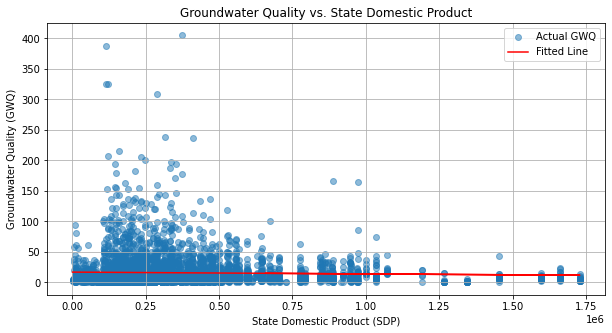

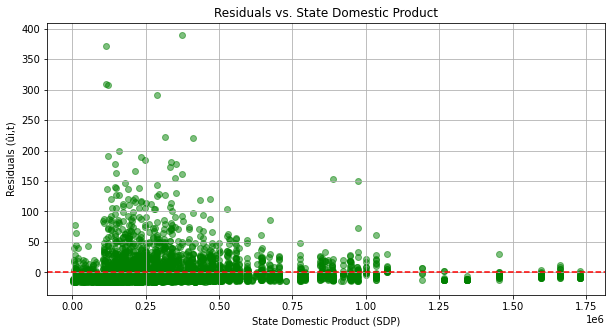

In [61]:
# Calculate the residuals
cleaned_data['residuals'] = results.resid

# Plot 1: GWQ vs SDP with the regression line
plt.figure(figsize=(10, 5))
plt.scatter(cleaned_data['GDP'], cleaned_data['potassium'], alpha=0.5, label='Actual GWQ')
plt.plot(cleaned_data['GDP'], results.fittedvalues, color='red', label='Fitted Line')
plt.title('Groundwater Quality vs. State Domestic Product')
plt.xlabel('State Domestic Product (SDP)')
plt.ylabel('Groundwater Quality (GWQ)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Residuals vs SDP
plt.figure(figsize=(10, 5))
plt.scatter(cleaned_data['GDP'], cleaned_data['residuals'], alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. State Domestic Product')
plt.xlabel('State Domestic Product (SDP)')
plt.ylabel('Residuals (ûi,t)')
plt.grid(True)
plt.show()


Question 3

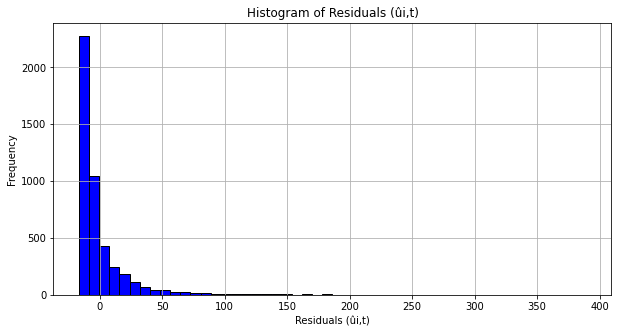

6.002665031701326e-11

In [62]:
# Plotting the histogram of the residuals
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data['residuals'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Residuals (ûi,t)')
plt.xlabel('Residuals (ûi,t)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Verification that the sum of the residuals is approximately 0
sum_of_residuals = cleaned_data['residuals'].sum()
sum_of_residuals

Sum is effectively 0 

Question 4

Setting up the model

b0 + b1GDP + b2GDP^2 + b3GDP^3 + delta1Gini + constant

In [65]:
def runner(data):
    data_clean = data.dropna(subset=['potassium','GDP','Gini'])
    #imputer = SimpleImputer(strategy='median')
    #data_clean[['GDP', 'Gini']] = imputer.fit_transform(data_clean[['GDP', 'Gini']])

    # Create polynomial features for GDP
    poly = PolynomialFeatures(degree=3, include_bias=False)
    gdp_poly = poly.fit_transform(data_clean[['GDP']])
    gdp_poly_df = pd.DataFrame(gdp_poly, columns=['GDP', 'GDP2', 'GDP3'], index=data_clean.index)

    # Merge polynomial GDP features back into the original dataframe
    data_clean = pd.concat([data_clean, gdp_poly_df[['GDP2', 'GDP3']]], axis=1)

    # Normalize 'GDP', 'Gini', 'potassium', 'GDP2', 'GDP3'
    scaler = StandardScaler()
    data_clean[['GDP', 'Gini', 'potassium', 'GDP2', 'GDP3']] = scaler.fit_transform(data_clean[['GDP', 'Gini', 'potassium', 'GDP2', 'GDP3']])

    # Check for outliers by looking at statistical descriptions
    data_clean_description = data_clean[['GDP', 'Gini', 'potassium', 'GDP2', 'GDP3']].describe()

    data_clean_description

    X = data_clean[['GDP', 'GDP2', 'GDP3', 'Gini']]
    X = sm.add_constant(X)

    # Define the dependent variable
    y = data_clean['potassium']

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Get the summary of the regression model
    model_summary = model.summary()
    print(model_summary)
    data_clean['predicted_potassium'] = model.predict(X)

# Sort data for plotting
    plot_data = data_clean.sort_values(by='GDP')

    # Import plotting libraries
   

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(plot_data['GDP'], plot_data['potassium'], color='blue', label='Actual Data')
    plt.plot(plot_data['GDP'], plot_data['predicted_potassium'], color='red', label='Predicted Kuznets Curve')
    plt.xlabel('Normalized GDP')
    plt.ylabel('Normalized Potassium')
    plt.title('Kuznets Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

   

Regression 

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     14.52
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           8.73e-12
Time:                        00:26:21   Log-Likelihood:                -6501.1
No. Observations:                4602   AIC:                         1.301e+04
Df Residuals:                    4597   BIC:                         1.304e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.99e-18      0.015   4.09e-16      1.0

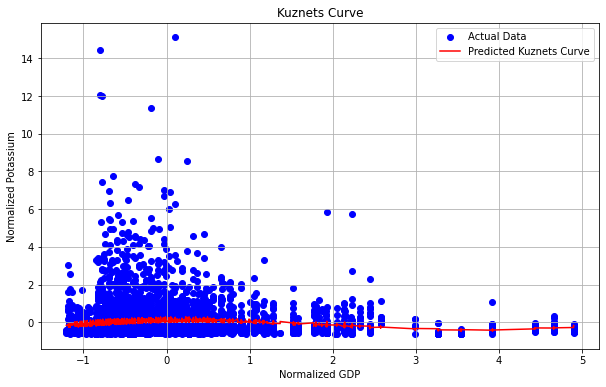

In [66]:
runner(cleaned_data)


Results - 

Outlier removal

Question 5

Inference from Q5 results

Question 6

Dividing the data for different time periods

In [ ]:
# Creating subsets of the data based on different time periods
data_2000_2004 = data[(data['year'] >= 2000) & (data['year'] <= 2004)]
data_2005_2009 = data[(data['year'] >= 2005) & (data['year'] <= 2009)]
data_2010_2014 = data[(data['year'] >= 2010) & (data['year'] <= 2014)]
data_2015_2018 = data[(data['year'] >= 2015) & (data['year'] <= 2018)]


(data_2000_2004.shape, data_2005_2009.shape, data_2010_2014.shape, data_2015_2018.shape)


((2070, 9), (2070, 9), (2046, 9), (1632, 9))

In [ ]:
runner(data_2000_2004)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.823
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           0.000748
Time:                        23:31:41   Log-Likelihood:                -1276.0
No. Observations:                 906   AIC:                             2562.
Df Residuals:                     901   BIC:                             2586.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.816e-17      0.033  -1.16e-15      1.0

In [ ]:
runner(data_2005_2009)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     17.20
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           9.45e-14
Time:                        23:31:41   Log-Likelihood:                -1768.4
No. Observations:                1270   AIC:                             3547.
Df Residuals:                    1265   BIC:                             3573.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.662e-18      0.027    1.7e-16      1.0

In [ ]:
runner(data_2010_2014)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     11.59
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           3.01e-09
Time:                        23:31:41   Log-Likelihood:                -1799.1
No. Observations:                1284   AIC:                             3608.
Df Residuals:                    1279   BIC:                             3634.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.072e-17      0.027   2.21e-15      1.0

In [ ]:
runner(data_2015_2018)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.141
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           0.000417
Time:                        23:31:41   Log-Likelihood:                -1610.2
No. Observations:                1142   AIC:                             3230.
Df Residuals:                    1137   BIC:                             3256.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.567e-17      0.029  -1.21e-15      1.0

Inferences -> Data is somewhat different for each time interval 

Question 7 

Examining if there are differences in the estimates of the Kuznets curve across regions within India.

In [ ]:
data = pd.read_excel('ECO/NORTH-EASTERN_REGION.xlsx')
runner(data)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     14.09
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           2.63e-10
Time:                        23:31:42   Log-Likelihood:                -310.52
No. Observations:                 237   AIC:                             631.0
Df Residuals:                     232   BIC:                             648.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.274e-16      0.059   2.16e-15      1.0

In [ ]:
data = pd.read_excel('ECO/EASTERN_REGION.xlsx')
runner(data)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     12.12
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           1.56e-09
Time:                        23:31:43   Log-Likelihood:                -976.74
No. Observations:                 705   AIC:                             1963.
Df Residuals:                     700   BIC:                             1986.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.778e-17      0.037   1.31e-15      1.0

In [ ]:
data = pd.read_excel('ECO/CENTRAL_REGION.xlsx')
runner(data)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5693
Date:                Sun, 28 Apr 2024   Prob (F-statistic):              0.685
Time:                        23:31:45   Log-Likelihood:                -1738.5
No. Observations:                1226   AIC:                             3487.
Df Residuals:                    1221   BIC:                             3513.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.933e-17      0.029   2.43e-15      1.0

In [ ]:
data = pd.read_excel('ECO/NORTHERN_REGION.xlsx')
runner(data)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     16.88
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           1.68e-13
Time:                        23:31:46   Log-Likelihood:                -1808.7
No. Observations:                1298   AIC:                             3627.
Df Residuals:                    1293   BIC:                             3653.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.126e-17      0.027  -2.26e-15      1.0

In [ ]:
data = pd.read_excel('ECO/SOUTHERN_REGION.xlsx')
runner(data)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.920
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           0.000678
Time:                        23:31:46   Log-Likelihood:                -681.28
No. Observations:                 487   AIC:                             1373.
Df Residuals:                     482   BIC:                             1394.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.392e-17      0.045  -1.66e-15      1.0

In [ ]:
data = pd.read_excel('ECO/WESTERN_REGION.xlsx')
runner(data)

                            OLS Regression Results                            
Dep. Variable:              potassium   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     7.024
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           1.59e-05
Time:                        23:31:47   Log-Likelihood:                -813.41
No. Observations:                 583   AIC:                             1637.
Df Residuals:                     578   BIC:                             1659.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.34e-16      0.041   -3.3e-15      1.0

There are signifant differences in the estimates of the Kuznets curve across regions within India.